# Moore’s Law Linear Regression

You are given a dataset describing Moore’s Law, stored in the file **`./datat/moore.csv`**.  
Each record contains information about the **year**, **transistor count**, and other details for integrated circuits.  
Your task is to implement a simple **linear regression model** in **PyTorch** to estimate the rate at which transistor counts have historically increased.

---
---

### Expected Output

- Scatter plots of data before and after preprocessing  
- A decreasing loss curve across epochs  
- A final fitted regression line  
- Calculated doubling‑time value (approximately **2 years** for real Moore’s Law data)


#### Your answer:

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import warnings
import re
warnings.filterwarnings('ignore')

In [56]:
# Loading data
data_dir = "/media/shayan/University/AI-Driven HEP/AI-Driven HEP Assignments /assignment-3-Shayan-Zavvarei/src/data/"
data_file = os.path.join(data_dir, "moore.csv")
# for reading the csv files we can use pandas library like below:
df = pd.read_csv(data_file, delimiter='\t', on_bad_lines='skip')

print(f"\n✓ Data loaded successfully")


✓ Data loaded successfully


In [71]:
# making list of years and transistors
year_col_idx = None
transistor_col_idx = None

for i, col in enumerate(df.columns):
    numeric_vals = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    valid_count = numeric_vals.notna().sum()
    
    if valid_count > len(df) * 0.5:
        min_val = numeric_vals.min()
        max_val = numeric_vals.max()
        
        if 1960 <= min_val <= 2030 and 1960 <= max_val <= 2025:
            year_col_idx = i
            print(f"✓ Year column: [{i}] '{col}'")
        
        elif max_val > 1000:
            transistor_col_idx = i
            print(f"✓ Transistor column: [{i}] '{col}'")

# Creating the list for pandas
year_col = df.columns[year_col_idx]
transistor_col = df.columns[transistor_col_idx]

✓ Transistor column: [1] '2,300'
✓ Year column: [2] '1971'


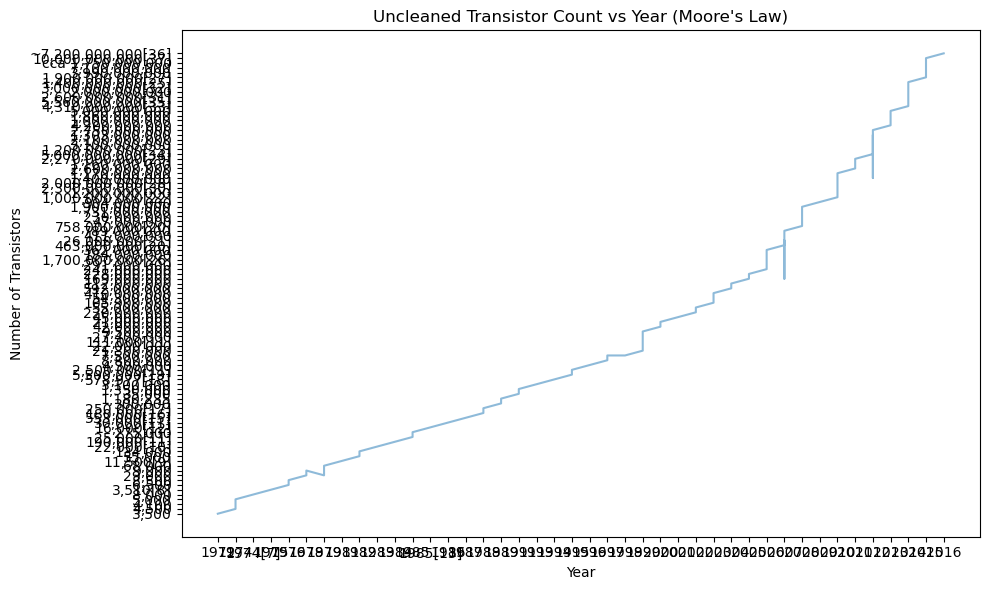

In [58]:
# Plotting raw data in linear space
plt.figure(figsize=(10, 6))
plt.plot(df[year_col], df[transistor_col], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Number of Transistors')
plt.title('Uncleaned Transistor Count vs Year (Moore\'s Law)')
plt.tight_layout()
plt.show()


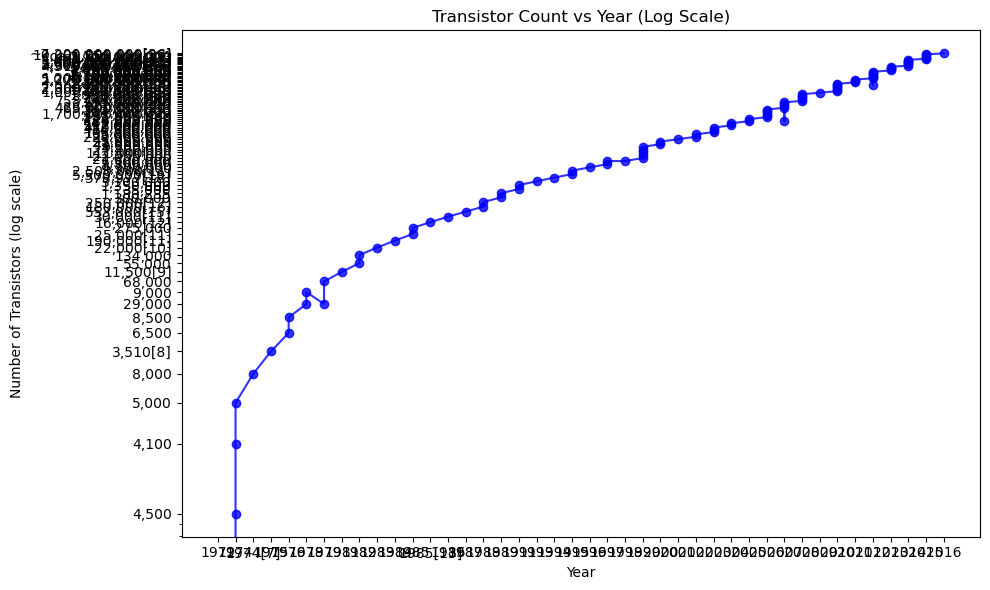

In [59]:
# Plotting raw data log space
plt.figure(figsize=(10, 6))
plt.semilogy(df[year_col], df[transistor_col], 'bo-', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Number of Transistors (log scale)')
plt.title('Transistor Count vs Year (Log Scale)')
plt.tight_layout()
plt.show()

first we need to prepare out data for training the model. since out model is a linear one:
($y = mx + b$)
we need x and y

In [ ]:
# We shall clean our data then make a list of cleaned data
def clean_value(val):
    if pd.isna(val):
        return np.nan
    val_str = str(val).replace(',', '')  
    val_str = re.sub(r'\[.*?\]', '', val_str) 
    try:
        return float(val_str)
    except:
        return np.nan

# Clean list for datas 
X = df[year_col].apply(clean_value).values.reshape(-1, 1)
y_raw = df[transistor_col].apply(clean_value).values

# deleting NaN in data files
mask = ~(np.isnan(X.flatten()) | np.isnan(y_raw))
X = X[mask]
y_raw = y_raw[mask]

# Log transform
y = np.log10(y_raw).reshape(-1, 1)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (99, 1), Shape of y: (99, 1)


In [74]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
inputs = torch.from_numpy(X_scaled.astype(np.float32))  
targets = torch.from_numpy(y.astype(np.float32))


#### Standardization with `StandardScaler`
`StandardScaler` standardizes features by removing the mean (μ) and scaling to unit variance $(σ = 1)$:

$[
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
]$

`fit_transform(X)` does two things:

- **Fits**: Learns the mean (μ) and standard deviation (σ) from the training data `X`.
- **Transforms**: Applies the standardization using those statistics.

**Why?** Many algorithms converge faster and more stably when input features are on a similar scale.

### Since torch uses random seeds for each run, we can fix a seed then start the training

In [75]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


#### our model is:
$\hat{y} = w \cdot x + b$

In [78]:
model = nn.Linear(in_features=1, out_features=1)
print(f" Weight: {model.weight.item():.4f}")
print(f" Bias: {model.bias.item():.4f}")

 Weight: -0.2343
 Bias: 0.9186


In [79]:
# Here we need loss and optimization functions using nn.MSELoss and optim.Adam
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(inputs)  
    loss = criterion(outputs, targets)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f" Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

print(f" Trained Weight: {model.weight.item():.4f}")
print(f" Trained Bias: {model.bias.item():.4f}")

 Epoch [100/1000], Loss: 0.337156
 Epoch [200/1000], Loss: 0.260123
 Epoch [300/1000], Loss: 0.224683
 Epoch [400/1000], Loss: 0.209425
 Epoch [500/1000], Loss: 0.203292
 Epoch [600/1000], Loss: 0.200996
 Epoch [700/1000], Loss: 0.200199
 Epoch [800/1000], Loss: 0.199942
 Epoch [900/1000], Loss: 0.199866
 Epoch [1000/1000], Loss: 0.199845
 Trained Weight: 1.9661
 Trained Bias: 7.3638


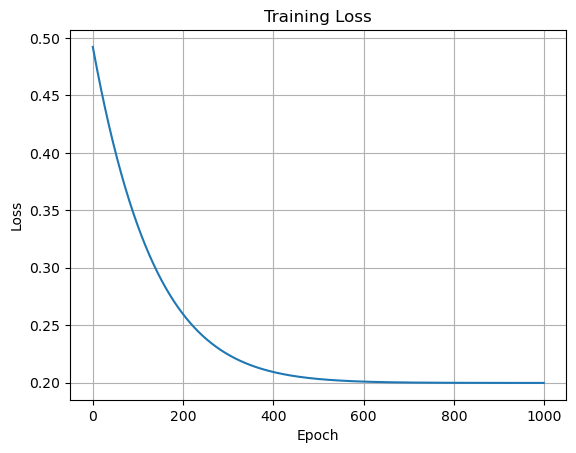

In [83]:
# Plotting the Loss function
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

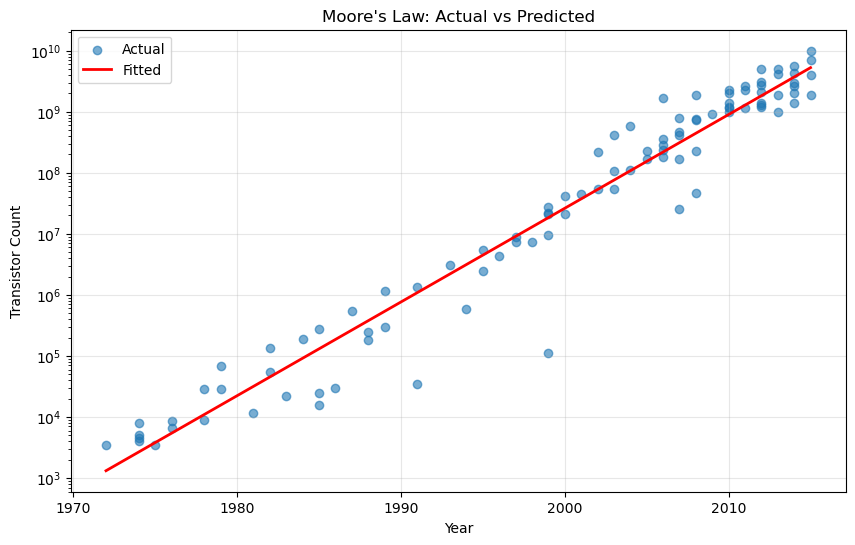

In [84]:
with torch.no_grad():
    predicted_log = model(inputs).numpy()  
    predicted_count = 10 ** predicted_log


X_original = X

# Sorting the data
sort_idx = np.argsort(X_original.flatten())
X_sorted = X_original[sort_idx]
y_raw_sorted = y_raw[sort_idx]
pred_sorted = predicted_count[sort_idx]

# Plotting the final visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted, y_raw_sorted, label='Actual', alpha=0.6)
plt.plot(X_sorted, pred_sorted, 'r-', linewidth=2, label='Fitted')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Transistor Count')
plt.title('Moore\'s Law: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [85]:
weight = model.weight.item()
bias = model.bias.item()

print(f"\nModel Parameters:")
print(f"Weight (slope in scaled space): {weight:.4f}")
print(f"Bias (intercept in scaled space): {bias:.4f}")


slope_original = weight / scaler.scale_[0]
print(f"Slope in original space: {slope_original:.6f}")

# Doubling time
doubling_time = np.log10(2) / slope_original
print(f"\nDoubling Time: {doubling_time:.2f} years")
print(f"Expected (Moore's Law): ~2 years")



Model Parameters:
Weight (slope in scaled space): 1.9661
Bias (intercept in scaled space): 7.3638
Slope in original space: 0.153538

Doubling Time: 1.96 years
Expected (Moore's Law): ~2 years
